In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from sklearn.linear_model import LogisticRegression
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import random
from tqdm import tqdm
import tensorflow as tf
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras import optimizers

## Load the images

In [2]:
datadir = './public_hand_dataset'
img_list =[]
target_list = []

for dir in glob(datadir + '/*/', recursive = True):
    img_file = glob(dir + 'original/*')[0]
    target_file = glob(dir + 'no_bg/*')[0]
    if (img_file.lower().endswith('jpeg') and target_file.lower().endswith('jpeg')) :
        img_list.append(img_file)
        target_list.append(target_file)


In [3]:
print(len(img_list))
print(len(target_list))

150
150


That is not a lot of data.

Let's try with a simple Logistic Regression before bringing out the big guns. Note that this model basically recognises skin colour and that the dataset is biased towards white people. Definitely something to change before putting in production.

Since the target are not saved as masks, we need to create them by selecting all non-black pixels from the target images.

In [4]:
# read the images and masks stored in the found paths

hand_images = []
for path in tqdm(img_list):
  image = cv.imread(path)
  hand_images.append(image)

hand_targets = []
hand_masks = []
for path in tqdm(target_list):
  target = cv.imread(path)
  hand_targets.append(target)

  _, mask = cv.threshold(target, 0, 255, cv.THRESH_BINARY)
  mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
  hand_masks.append(mask)

  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:17<00:00,  8.77it/s]


Let's plot some images to see what the data looks like

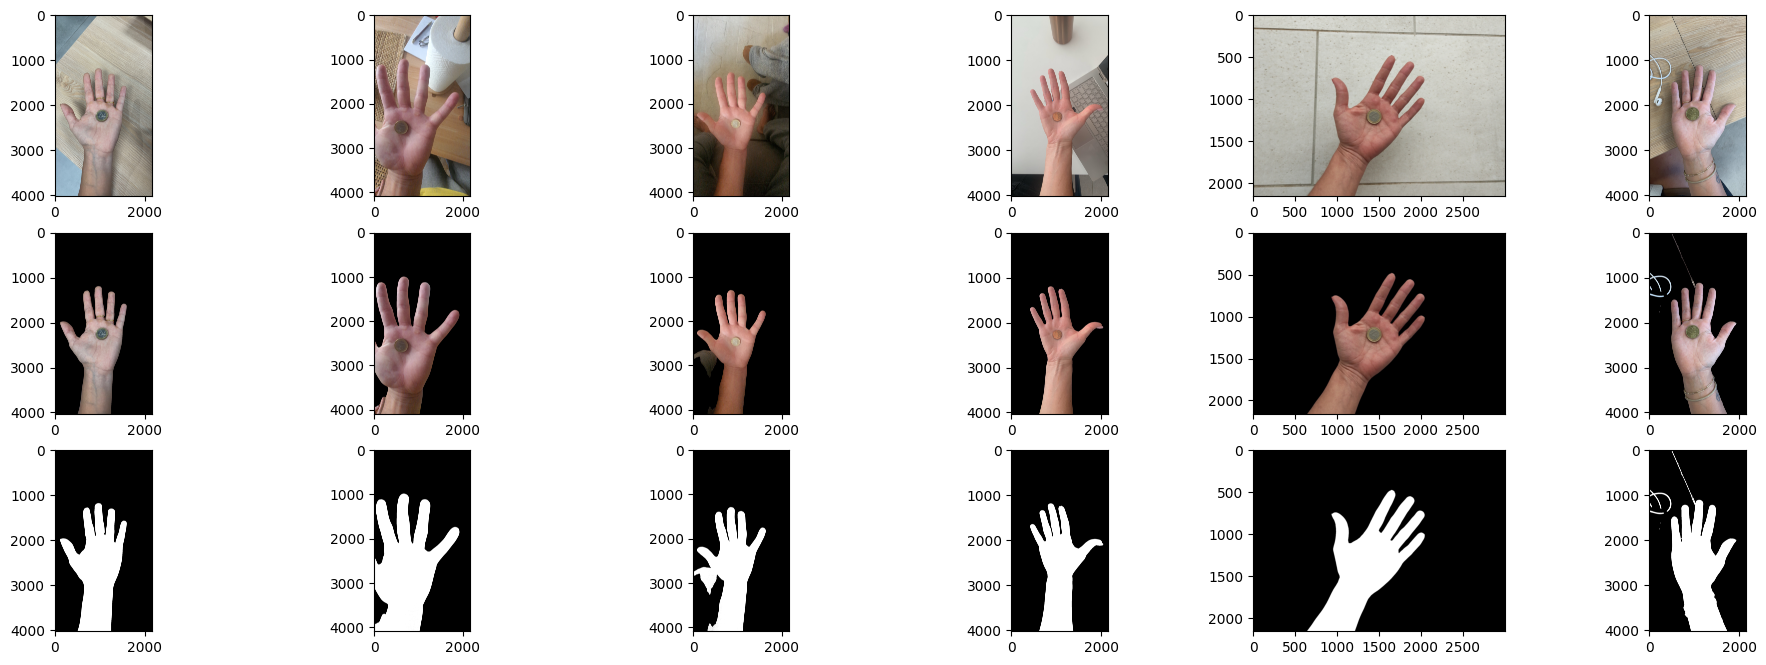

In [5]:
# Choose how many examples we want
k = 6

# Create the appropriate subplots
fig, ax = plt.subplots(nrows=3, ncols=k, figsize=(4*k, 8))

# Cycle through a random selection of k images
for i, j in enumerate(random.sample(range(len(hand_images)), k)):

  example_img = hand_images[j]
  example_targ = hand_targets[j]
  example_mask = hand_masks[j]

  # Show the original image, predicted map and ground truth map
  ax[0, i].imshow(cv.cvtColor(hand_images[j], cv.COLOR_BGR2RGB))
  ax[1, i].imshow(cv.cvtColor(hand_targets[j], cv.COLOR_BGR2RGB))
  ax[2, i].imshow(hand_masks[j], cmap='gray')

Note that there are some artefacts in the target images.

To work with segmentation it is better to use the HSV format so let's transform the input images.

In [6]:
hand_images_HSV = []
for image in tqdm(hand_images):
  # convert from BGR to HSV colorspace for easier classification later
  image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
  hand_images_HSV.append(image)

100%|██████████| 150/150 [00:02<00:00, 62.53it/s]


Let's resize the image so they are easier to work with

In [7]:
# Resize all images to a standard size
# convert the image and mask to float-arrays and normalise their values to be between 0 and 1

res_images = []
res_targets = []
res_masks = []

new_size = (224, 224)

for i in range(len(hand_images)):
  res_images.append(cv.resize(hand_images_HSV[i], new_size).astype('float32') / 255)
  res_targets.append(cv.resize(hand_targets[i], new_size).astype('float32') / 255)
  res_masks.append(cv.resize(hand_masks[i], new_size).astype('float32') / 255)

In [8]:
# flatten the images and masks for logistic regression classification

flat_images = []
flat_masks = []

for i in tqdm(range(len(hand_images))):
  flat_images.append(res_images[i].reshape((-1, 3)))

  # flip the 0 and 1s, so 1 is the existence of a hand and 0 otherwise
  flat_masks.append(res_masks[i].astype(int).reshape((-1, 1)))

100%|██████████| 150/150 [00:00<00:00, 3537.47it/s]


In [10]:
# Concatenate all the data into two arrays for training
X = np.concatenate(flat_images)
y = np.concatenate(flat_masks)

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=13)

In [11]:
# Build the logistic regression model
model_lr = LogisticRegression(verbose=True)
model_lr.fit(X_train, y_train.ravel())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.17352D+06    |proj g|=  1.49225D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     23      1     0     0   3.281D-02   2.658D+06
  F =   2658441.4999699681     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


LogisticRegression(verbose=True)

In [12]:
# Check accuracy metric
print(model_lr.score(X_train, y_train))
print(model_lr.score(X_test, y_test))

0.8110673761692176
0.8106598107993197


In [13]:
print(precision_score(y_train.reshape((-1)).astype(int), model_lr.predict_proba(X_train.reshape((-1, 3)))[:,1] > 0.6))
print(precision_score(y_test.reshape((-1)).astype(int), model_lr.predict_proba(X_test.reshape((-1, 3)))[:,1] > 0.6))

print(recall_score(y_train.reshape((-1)).astype(int), model_lr.predict_proba(X_train.reshape((-1, 3)))[:,1] > 0.6))
print(recall_score(y_test.reshape((-1)).astype(int), model_lr.predict_proba(X_test.reshape((-1, 3)))[:,1] > 0.6))

print(f1_score(y_train.reshape((-1)).astype(int), model_lr.predict_proba(X_train.reshape((-1, 3)))[:,1] > 0.6))
print(f1_score(y_test.reshape((-1)).astype(int), model_lr.predict_proba(X_test.reshape((-1, 3)))[:,1] > 0.6))

0.7209009876579979
0.7216336068403303
0.2869524096183193
0.28591192553412537
0.4105046945592108
0.4095569826519252


Now we have a becnhmark. Let's plot some results

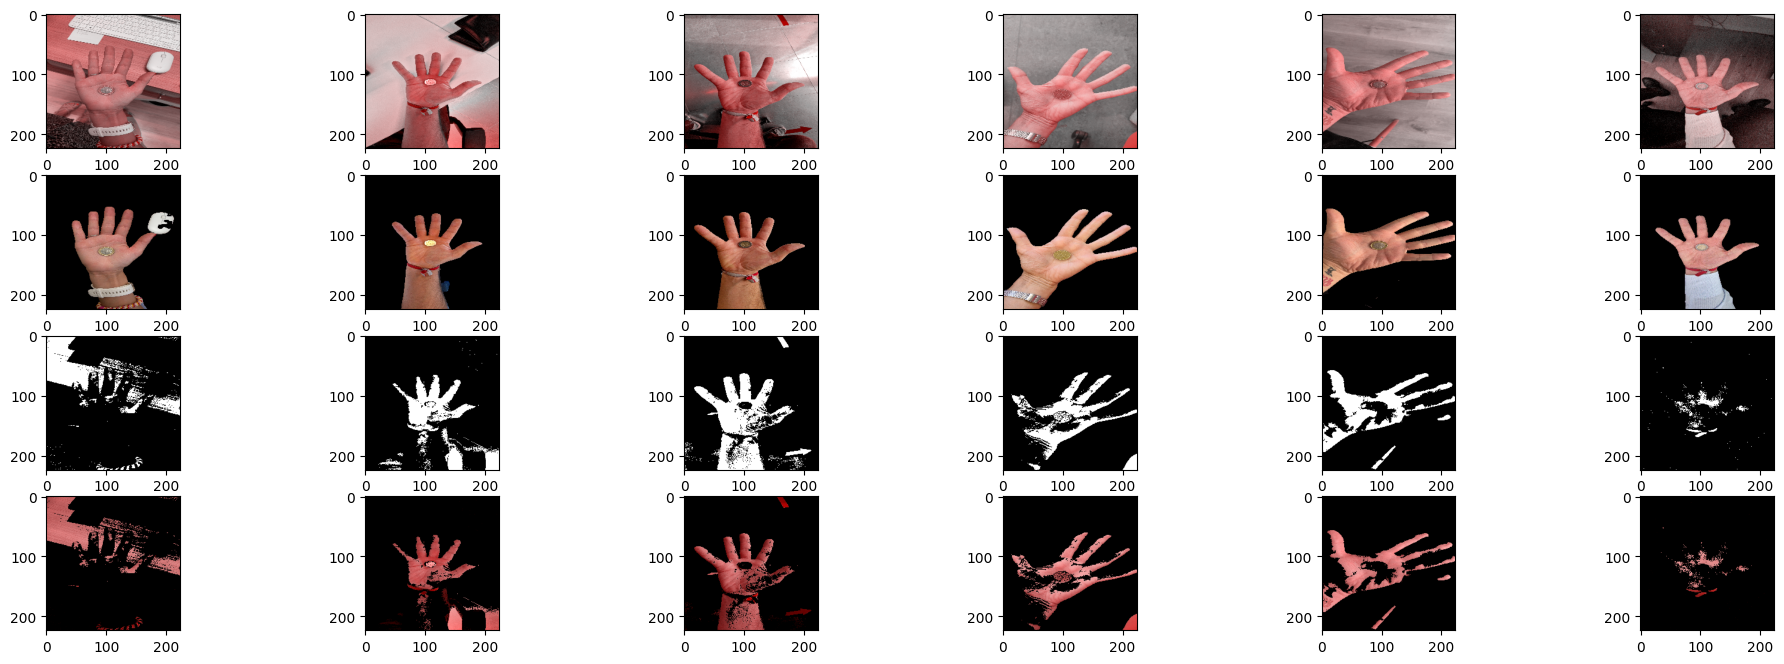

In [14]:
# Choose how many examples we want
k = 6

# Create the appropriate subplots
fig, ax = plt.subplots(nrows=4, ncols=k, figsize=(4*k, 8))

# Cycle through a random selection of k images
for i, j in enumerate(random.sample(range(len(hand_images)), k)):

  example_img = res_images[j]
  example_targ = res_targets[j]
  example_mask = res_masks[j]

  # Pre-process the images to feed them to the Model
  flat_ex = example_img.reshape((-1, 3))

  # Feed the images through the model
  pred_mask_ex = (model_lr.predict_proba(flat_ex)[:, 1] > 0.6)

  # Reshape the output back to a 2-D image format
  pred_mask_ex = pred_mask_ex.reshape(example_img.shape[:2])

  # Apply the mask to the original image
  masked_array = np.zeros_like(example_img)
  masked_array[pred_mask_ex] = example_img[pred_mask_ex]

  # Show the original image, predicted map and ground truth map
  ax[0, i].imshow(cv.cvtColor(example_img, cv.COLOR_HSV2RGB))
  ax[1, i].imshow(cv.cvtColor(example_targ, cv.COLOR_BGR2RGB))
  ax[2, i].imshow(pred_mask_ex*255, cmap='gray')
  ax[3, i].imshow(cv.cvtColor(masked_array, cv.COLOR_HSV2RGB))

Some features are visible but it's not perfect. We could do some optimasation, for example by tweaking the threshold but let's move on.

## U-Net

Let's try a U-net to segment the images.
Maybe we should augment the dataset to create more images

In [15]:
X = np.array(res_images)
y = np.array(res_masks)
indices = np.arange(len(res_images))

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.20, random_state=13)

In [16]:
from skimage.transform import rotate

X_train_rot = []
y_train_rot = []
X_train_flip = []
y_train_flip = []

for i in tqdm(range(len(X_train))):
  theta = random.randint(0, 359)
  X_train_rot.append(rotate(X_train[i], angle=theta))
  y_train_rot.append(rotate(y_train[i], angle=theta))

  X_train_flip.append(cv.flip(X_train[i], -1))
  y_train_flip.append(cv.flip(y_train[i], -1))

X_train_rot = np.array(X_train_rot)
y_train_rot = np.array(y_train_rot)
X_train_flip = np.array(X_train_flip)
y_train_flip = np.array(y_train_flip)

100%|██████████| 120/120 [00:00<00:00, 525.98it/s]


In [17]:
X_train = np.concatenate([X_train, X_train_rot, X_train_flip])
y_train = np.concatenate([y_train, y_train_rot, y_train_flip])

del X_train_rot
del y_train_rot
del X_train_flip
del y_train_flip

In [19]:
# Set up hyperparameters

batch_size = 32
epochs = 50
inChannel = 3
x, y = 224, 224
input_img = Input(shape = (x, y, inChannel))

Define the U-net

In [20]:
def unet(input_img):

  # First block Going down
  d1_2 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  d1_3 = Conv2D(16, (3, 3), activation='relu', padding='same')(d1_2)

  # Second block Going down
  d2_1 = MaxPooling2D()(d1_3)
  d2_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(d2_1)
  d2_3 = Conv2D(32, (3, 3), activation='relu', padding='same')(d2_2)

  # Third block Going down
  d3_1 = MaxPooling2D()(d2_3)
  d3_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(d3_1)
  d3_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(d3_2)

  # Fourth block Going down
  d4_1 = MaxPooling2D()(d3_3)
  d4_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(d4_1)
  d4_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(d4_2)

  # Fifth block 
  d5_1 = MaxPooling2D()(d4_3)
  d5_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(d5_1)
  d5_3 = Conv2D(256, (3, 3), activation='relu', padding='same')(d5_2)

  # Fourth block going up, concatenated with Fourth block going down
  up4_0 = UpSampling2D((2, 2))(d5_3)
  up4_1 = tf.keras.layers.concatenate([d4_3, up4_0])
  up4_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up4_1)
  up4_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up4_2)

  # Third block going up, concatenated with Third block going down
  up3_0 = UpSampling2D((2, 2))(up4_3)
  up3_1 = tf.keras.layers.concatenate([d3_3, up3_0])
  up3_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3_1)
  up3_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3_2)

  # Second block going up, concatenated with Second block going down
  up2_0 = UpSampling2D((2, 2))(up3_3)
  up2_1 = tf.keras.layers.concatenate([d2_3, up2_0])
  up2_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2_1)
  up2_3 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2_2)

  # First block going up, concatenated with First block going down
  up1_0 = UpSampling2D((2, 2))(up2_3)
  up1_1 = tf.keras.layers.concatenate([d1_3, up1_0])
  up1_2 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1_1)
  up1_3 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1_2)

  # Output
  out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(up1_3)

  return out

In [21]:
unet = Model(input_img, unet(input_img))
unet.compile(loss='mean_squared_error', optimizer = optimizers.legacy.Adam())

2023-10-08 13:52:25.815762: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-10-08 13:52:25.815902: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-08 13:52:25.815935: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-08 13:52:25.816189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-08 13:52:25.816561: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Let's start training

In [22]:
unet_train = unet.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50


2023-10-08 13:52:30.846946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 22s 1s/step - loss: 0.2200 - val_loss: 0.1880
Epoch 2/50
12/12 [==============================] - 9s 685ms/step - loss: 0.1801 - val_loss: 0.1444
Epoch 3/50
12/12 [==============================] - 8s 701ms/step - loss: 0.1518 - val_loss: 0.1266
Epoch 4/50
12/12 [==============================] - 8s 666ms/step - loss: 0.1355 - val_loss: 0.1187
Epoch 5/50
12/12 [==============================] - 8s 691ms/step - loss: 0.1202 - val_loss: 0.0843
Epoch 6/50
12/12 [==============================] - 8s 674ms/step - loss: 0.0951 - val_loss: 0.1168
Epoch 7/50
12/12 [==============================] - 8s 672ms/step - loss: 0.1055 - val_loss: 0.0728
Epoch 8/50
12/12 [==============================] - 8s 657ms/step - loss: 0.0859 - val_loss: 0.0708
Epoch 9/50
12/12 [==============================] - 8s 653ms/step - loss: 0.0813 - val_loss: 0.0624
Epoch 10/50
12/12 [==============================] - 8s 657ms/step - loss: 0.0766 - val_loss: 0.0712
Epoch 11/50


Plot some results

1/1 [==============================] - 0s 79ms/step


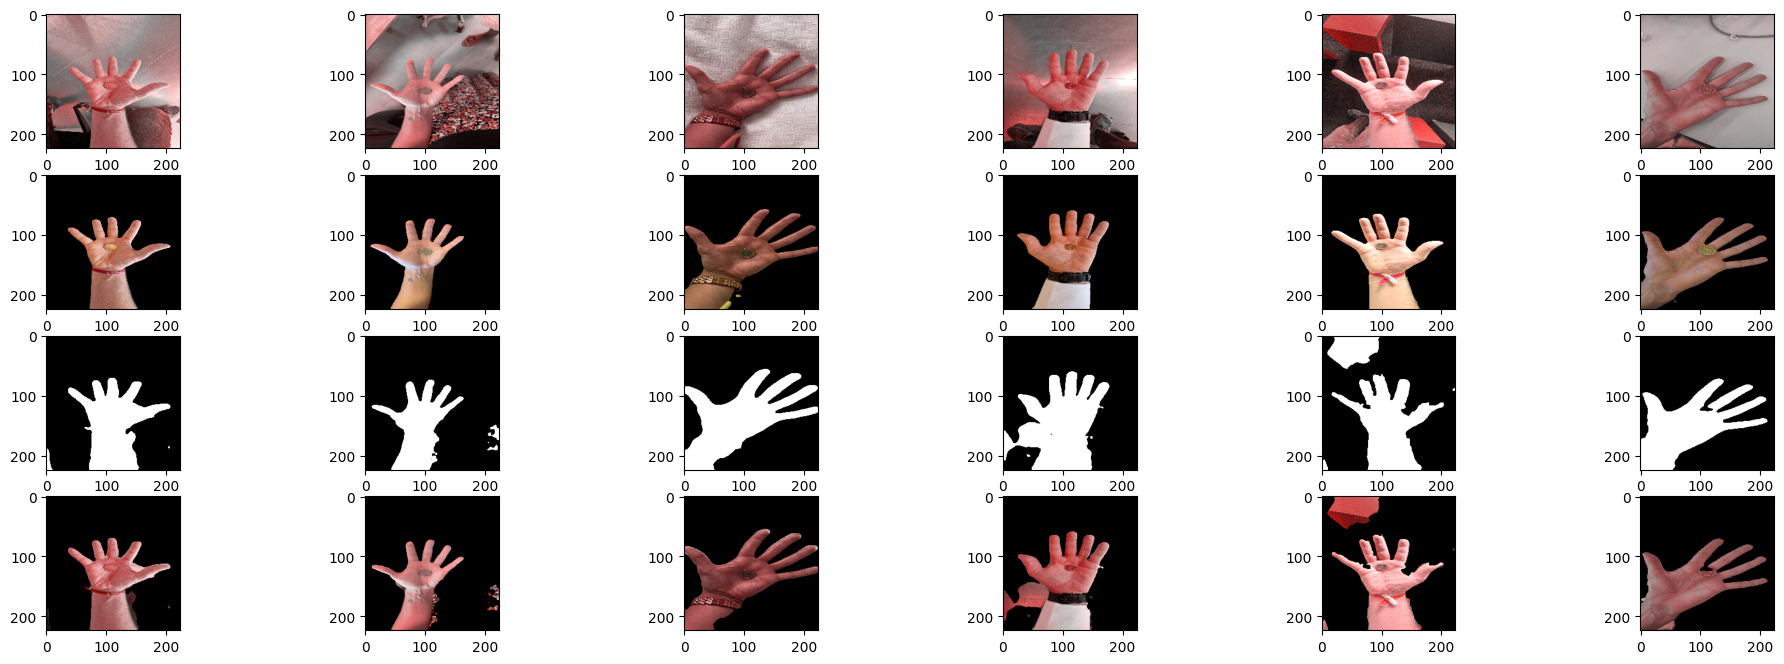

In [32]:
# Choose how many examples we want
k = 6

# Create the appropriate subplots
fig, ax = plt.subplots(nrows=4, ncols=k, figsize=(4*k, 8))

sample = random.sample(range(len(y_test)), k)
preds = -1 * unet.predict(X_test[sample]) + 1

# Cycle through a random selection of k images
for i, j in enumerate(sample):
  
  example_img = X_test[j]
  example_targ = res_targets[indices_test[j]]
  example_mask = y_test[j]

  # Feed the images through the model
  pred_mask_ex = (preds[i] <= 0.6)

  # Reshape the output back to a 2-D image format
  pred_mask_ex = pred_mask_ex.reshape((224, 224))

  # Apply the mask to the original image
  masked_array = np.zeros_like(example_img)
  masked_array[pred_mask_ex] = example_img[pred_mask_ex]

  # Show the original image, predicted map and ground truth map
  ax[0, i].imshow(cv.cvtColor(example_img, cv.COLOR_HSV2RGB))
  ax[1, i].imshow(cv.cvtColor(example_targ, cv.COLOR_BGR2RGB))
  ax[2, i].imshow(pred_mask_ex*255, cmap='gray')
  ax[3, i].imshow(cv.cvtColor(masked_array, cv.COLOR_HSV2RGB))

Pretty good for a few hours work and definitely better than the logistic regression model. Better results could be gotten by for example:
- improving the mask that is used as a label
- tuning the hyperparameter
- adding more external 

It would also be interesting testing a Vision transformer. But this requires a large amount of data so definetly external data would need to be used. Or finetune a pre-trained transformed model.